## Turbines Distances

In [10]:
import numpy as np
import pandas as pd

import glob #to find filenames from directory matching a pattern
import feather
from scipy.spatial.distance import euclidean #to find euclidean distance between points
from fastdtw import fastdtw #to find DTW distance
from scipy.cluster.hierarchy import ward, dendrogram, fcluster #for hierarchical clustering
from sklearn.preprocessing import MinMaxScaler
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


In [35]:
feats = ['power', 'rotor_speed', 'wind_speed', 'gearbox_bearing_temperature', 'gearbox_oil_temperature', 
         'nacelle_temperature', 'ambient_temperature']

In [36]:
def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms

def kurtosis(data):
    norm_data = data - np.mean(data)
    if sum(norm_data) == 0:
        return np.nan
    ku = np.mean(norm_data**4)/np.mean(norm_data**2)**2
    return ku

feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 'nacelle_temperature']
feats_2 = ['wind_speed', 'ambient_temperature']

agg_dict = {i:['mean', np.std, 'min', 'max', rms, kurtosis] for i in feats_1}
agg_dict.update({i:['mean', np.std, 'min', 'max'] for i in feats_2})

In [37]:
def limits(data):
    q1, q3= np.percentile(data,[25,75])
    iqr = q3 - q1 
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound
    

def prep_df(turbine_ids, shutdown = 0):
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        temp_df.drop(['wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault'], axis = 1, inplace = True)
                
        shutdown_date = pd.to_datetime(shutdown).date()
        temp_df = temp_df[temp_df.Date <= shutdown_date]
        
        for feat in feats:
            
            l, u = limits(temp_df[feat])
            temp_df[feat][(temp_df[feat] < l) | (temp_df[feat] > u)] = temp_df[feat].median()
        
        df = df.append(temp_df)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df.dropna(inplace = True)
    
    df.drop('turbine_id', inplace = True, axis = 1)
    df = df.set_index('Date')
    return df

### Clustering Turbines

In [14]:
sc = MinMaxScaler()

In [15]:
hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

# ids of healthy turbines
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83,\
          85, 86, 92, 93, 94, 95, 97]

#### Cluster 1: Turbines 2, 3, 5, 6, 11, 19

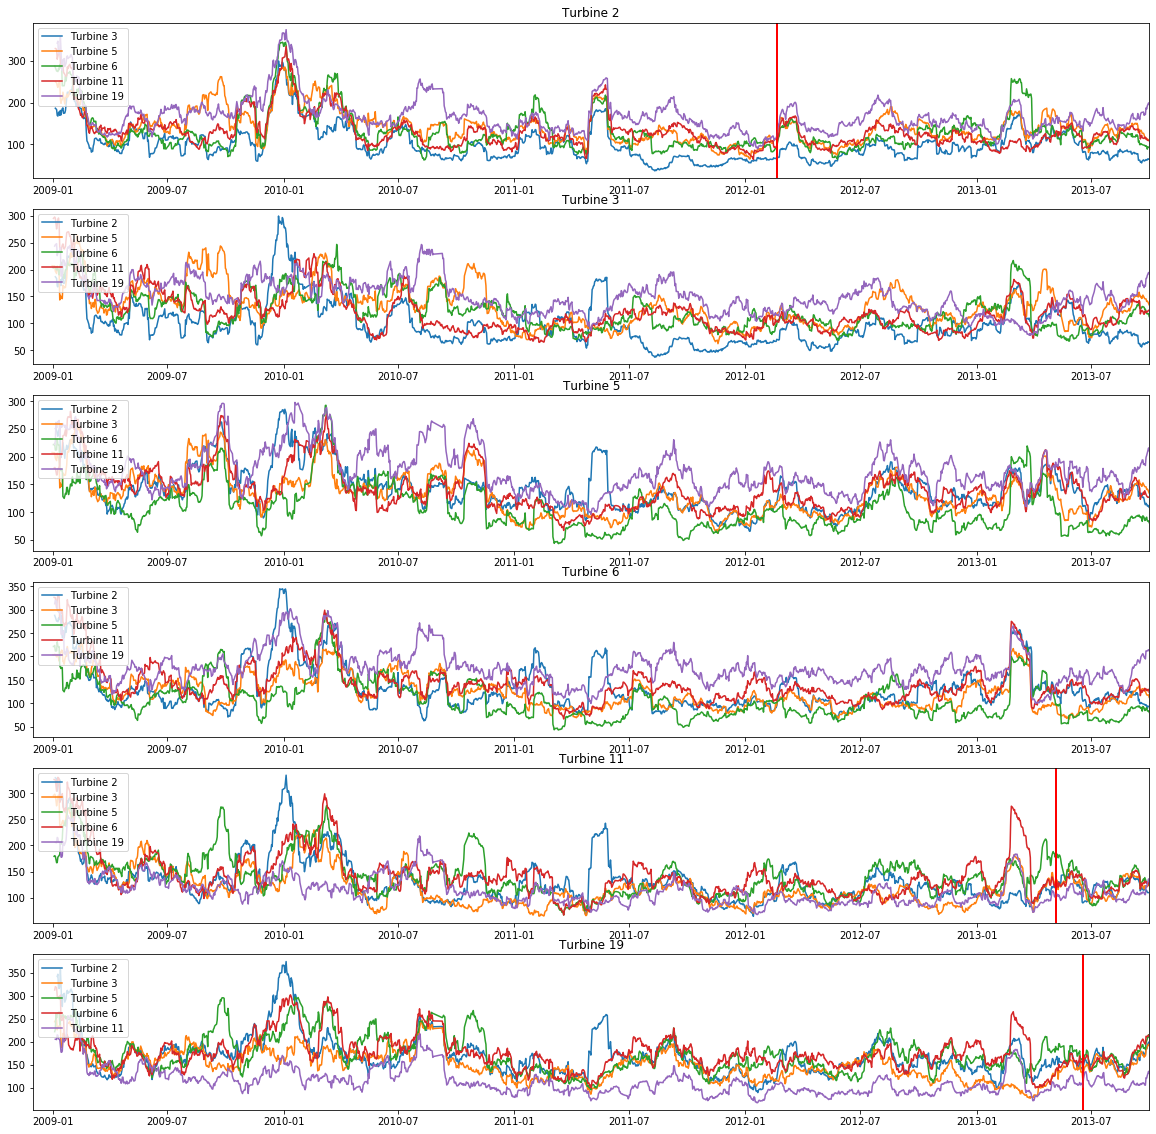

In [38]:
ids = [2, 3, 5, 6, 11, 19]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]
        
fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 2: Turbines 24, 26, 29, 30, 31

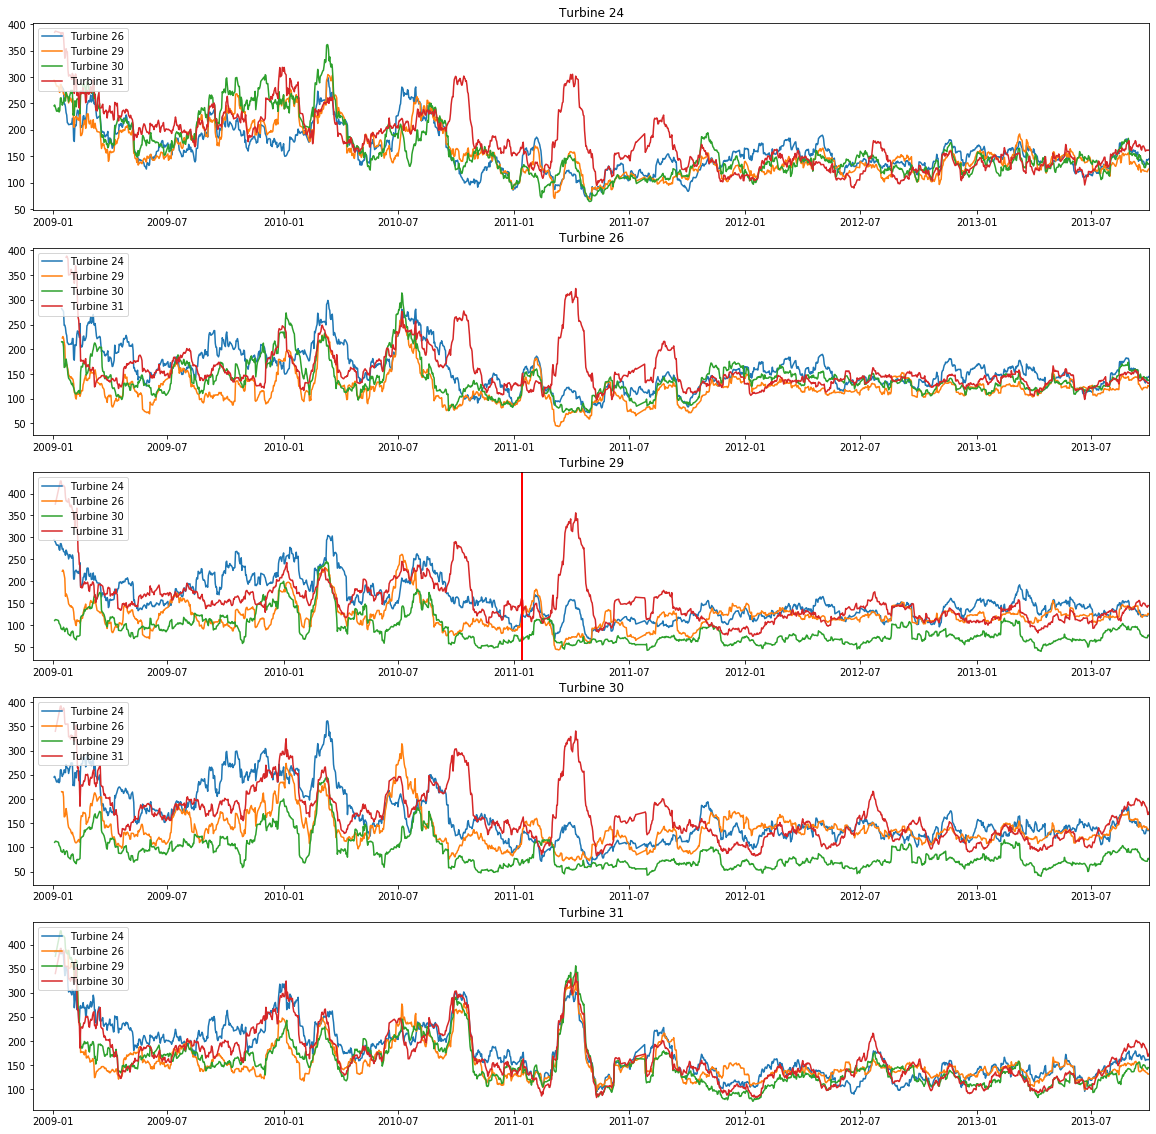

In [39]:
ids = [24, 26, 29, 30, 31]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 3: Turbines 34, 35, 36, 37, 38

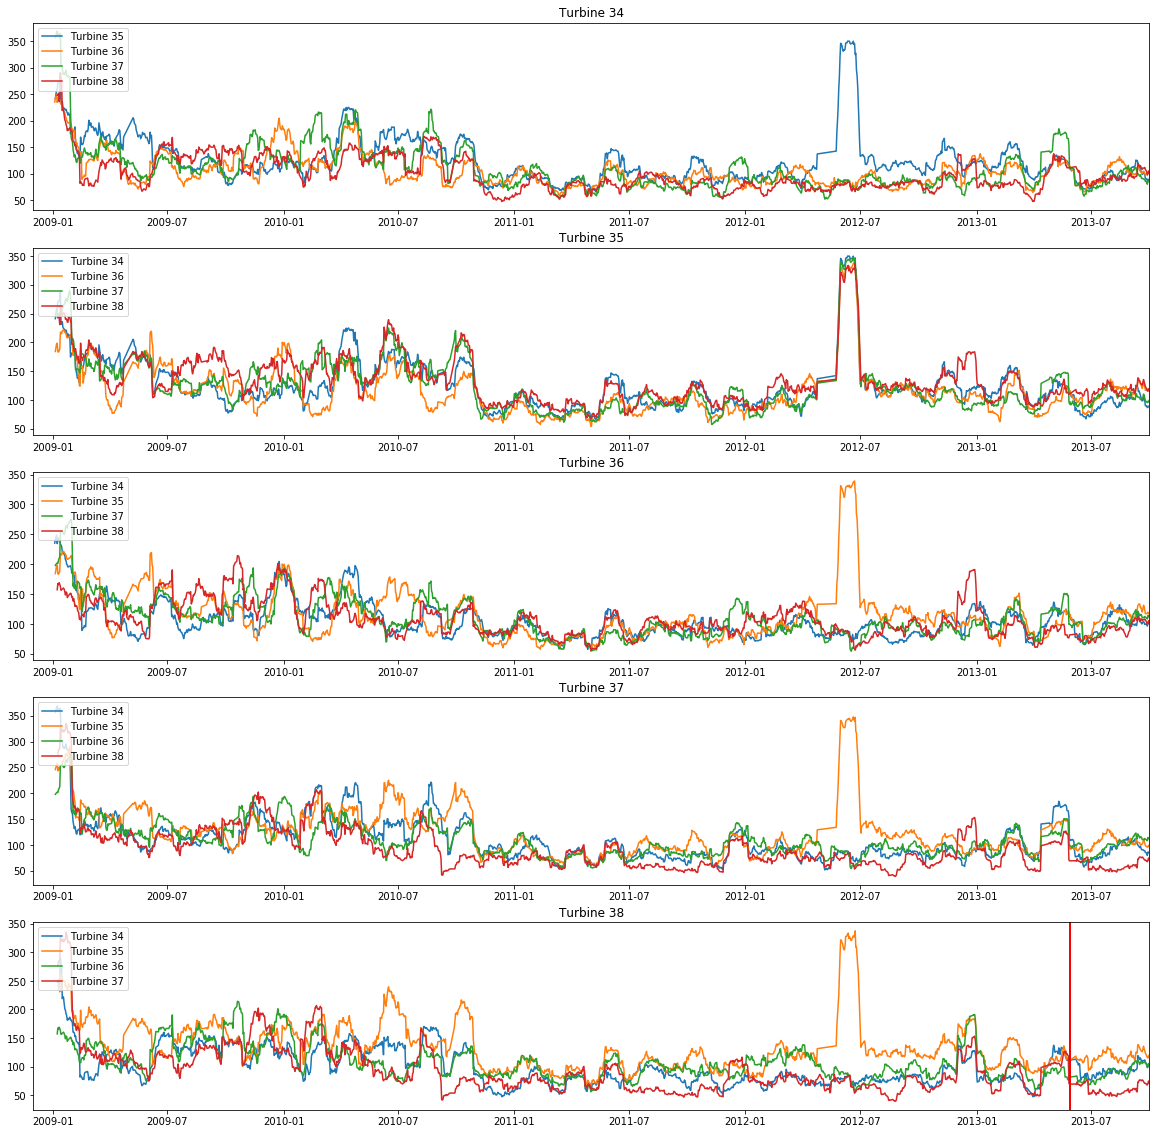

In [40]:
ids = [34, 35, 36, 37, 38]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 4: Turbines 53, 55, 59, 63, 64, 65, 66, 69

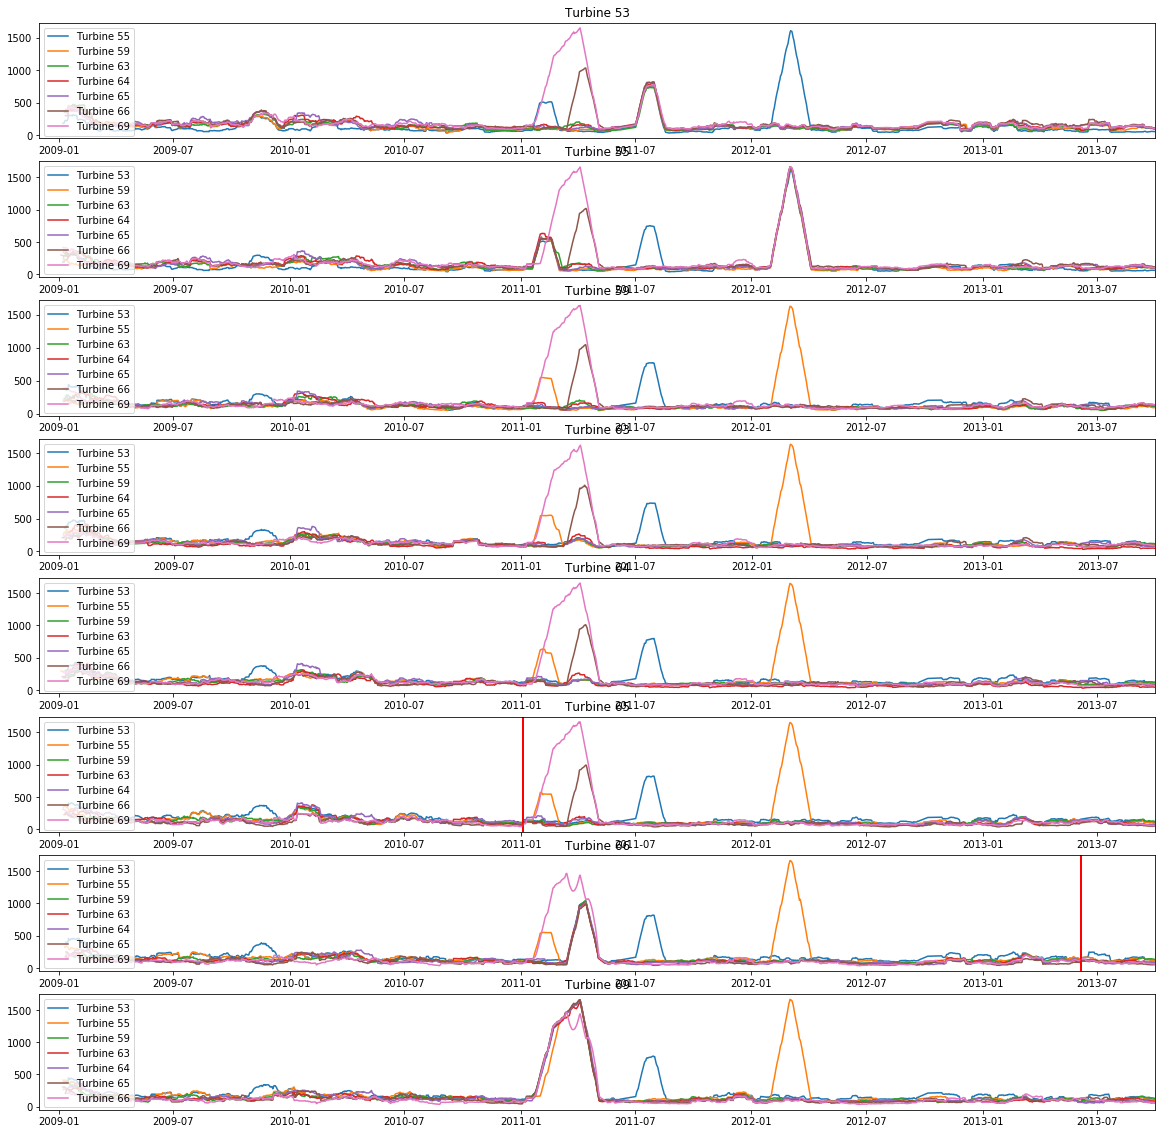

In [41]:
ids = [53, 55, 59, 63, 64, 65, 66, 69]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 5: Turbines 70, 73, 76, 77, 78

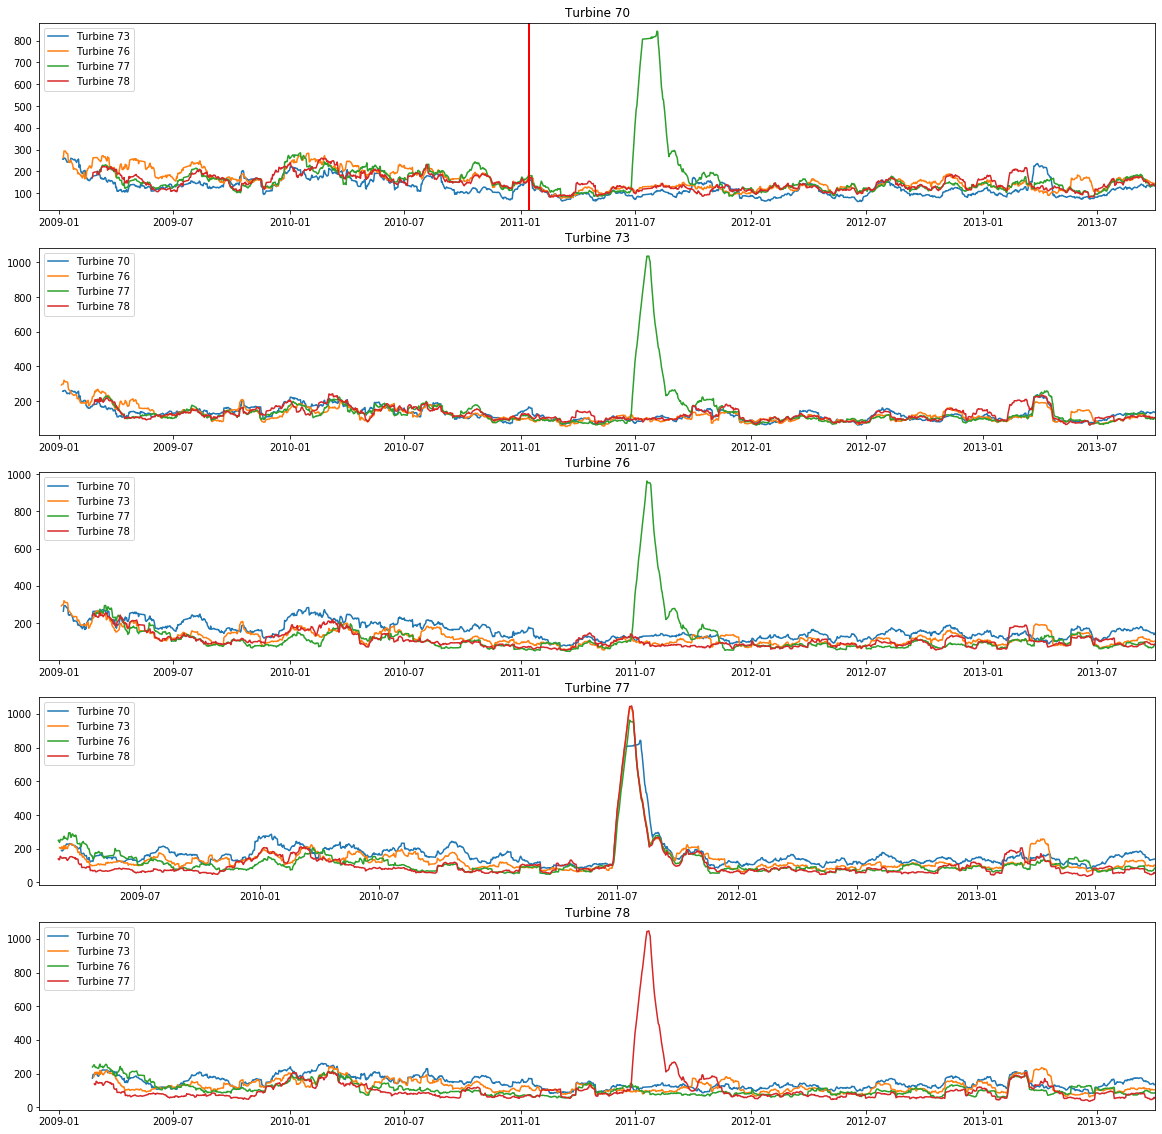

In [42]:
ids = [70, 73, 76, 77, 78]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 6: Turbines 79, 80, 81, 82, 83, 84, 85, 86

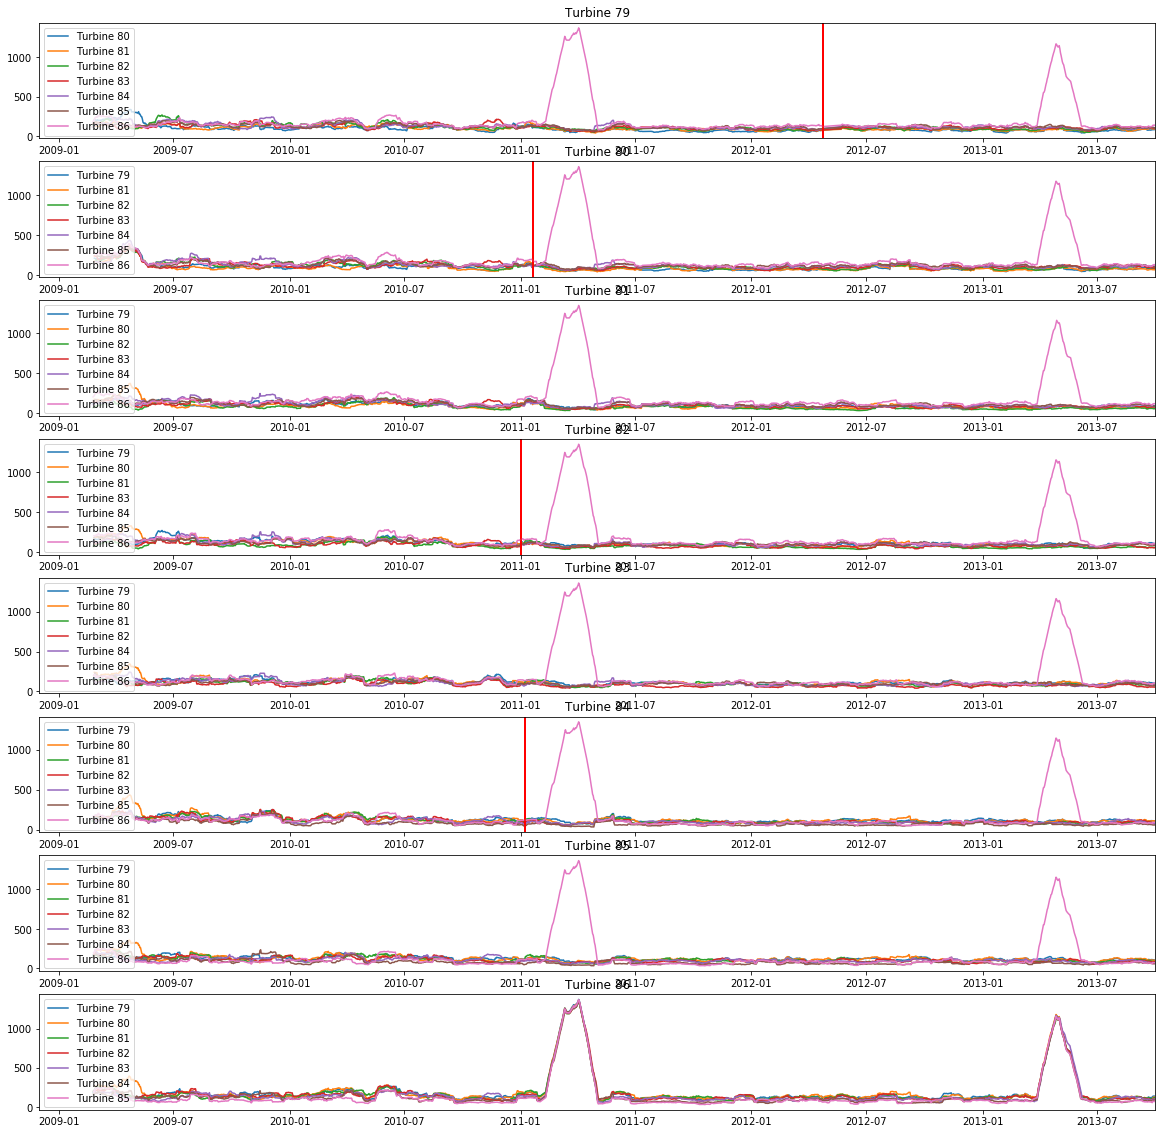

In [43]:
ids = [79, 80, 81, 82, 83, 84, 85, 86]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

#### Cluster 6: Turbines 92, 93, 94, 95, 97

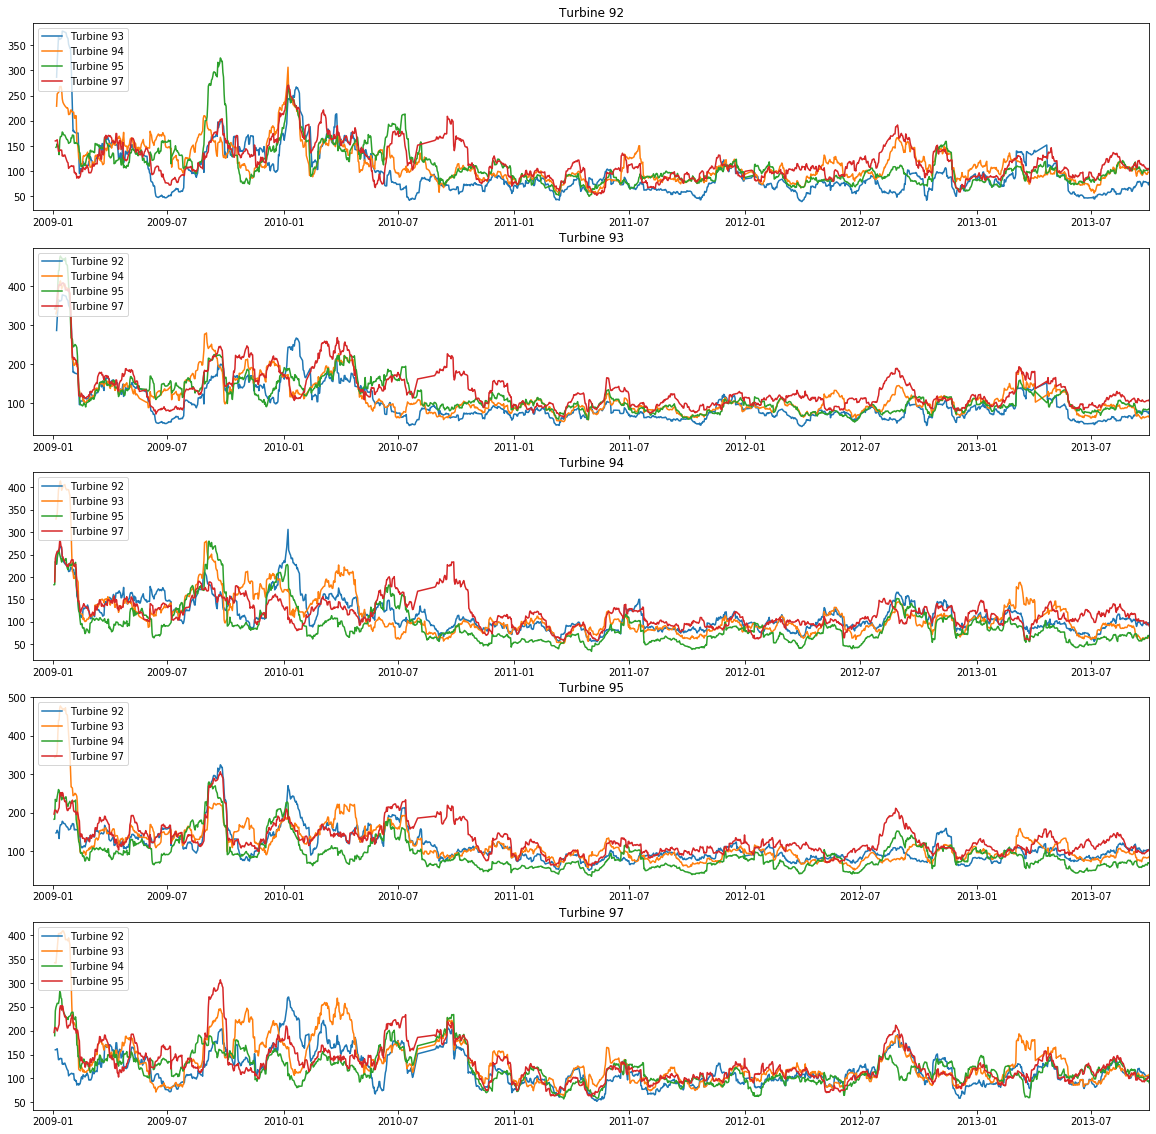

In [44]:
ids = [92, 93, 94, 95, 97]
date = "2013-10-01"

dfs = {}
distances = {}

for i, tub in enumerate(ids):
    dfs[i] = prep_df(turbine_ids = [tub], shutdown=date)

for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distances[i,j] = np.sqrt(((dfs[i]-dfs[j]).dropna(axis = 0)**2).sum(axis = 1))
        distances[j,i] = distances[i,j]

fig, axes = plt.subplots(figsize = (20, 20), nrows=len(ids))
for i in range(0, len(ids)):
    for j in range(0, len(ids)):
        axes[i].set_title(label = "Turbine " + str(ids[i]))
        if i != j:  
            distances[i,j].rolling(window=30).mean().plot(ax = axes[i], label = "Turbine " + str(ids[j]))
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == ids[i]].iloc[0])
            if(pd.notnull(shutdown_date)):
                axes[i].axvline(x=shutdown_date, color = "red")
            axes[i].set_xlabel("")
            axes[i].legend(loc = 2)

### Dtw clustering 

#### Cluster 1: Turbines 2, 3, 5, 6, 11, 19

In [48]:
ids = [2, 3, 5, 6, 11, 19]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [49]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


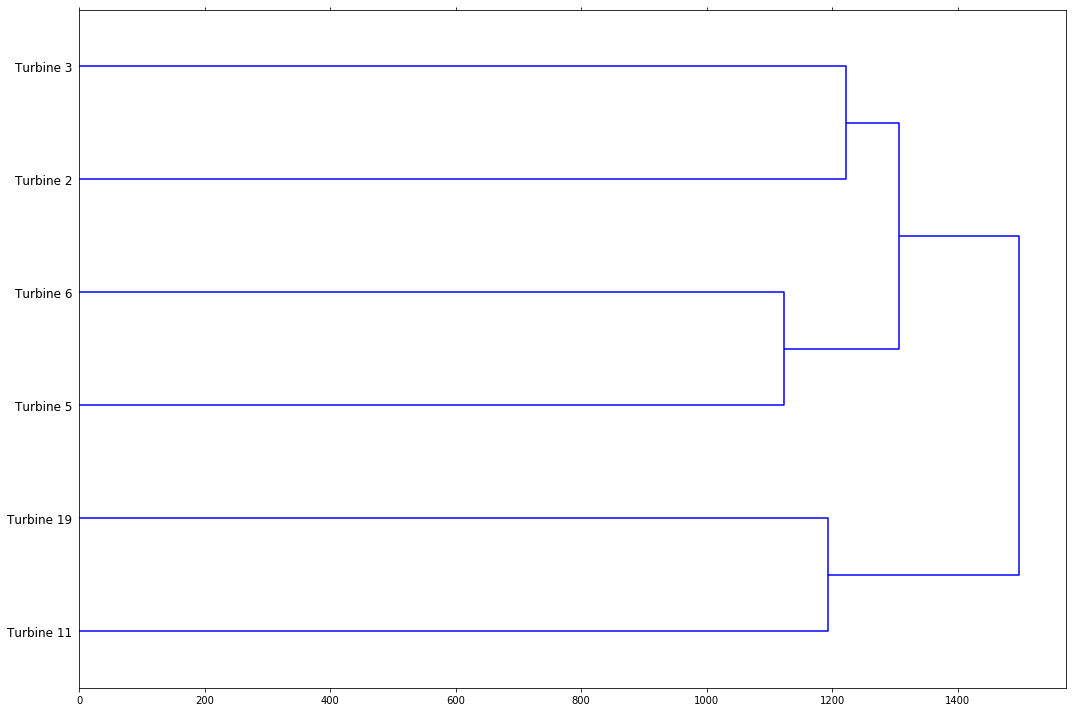

In [50]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 2: Turbines 24, 26, 29, 30, 31

In [51]:
ids = [24, 26, 29, 30, 31]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [52]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


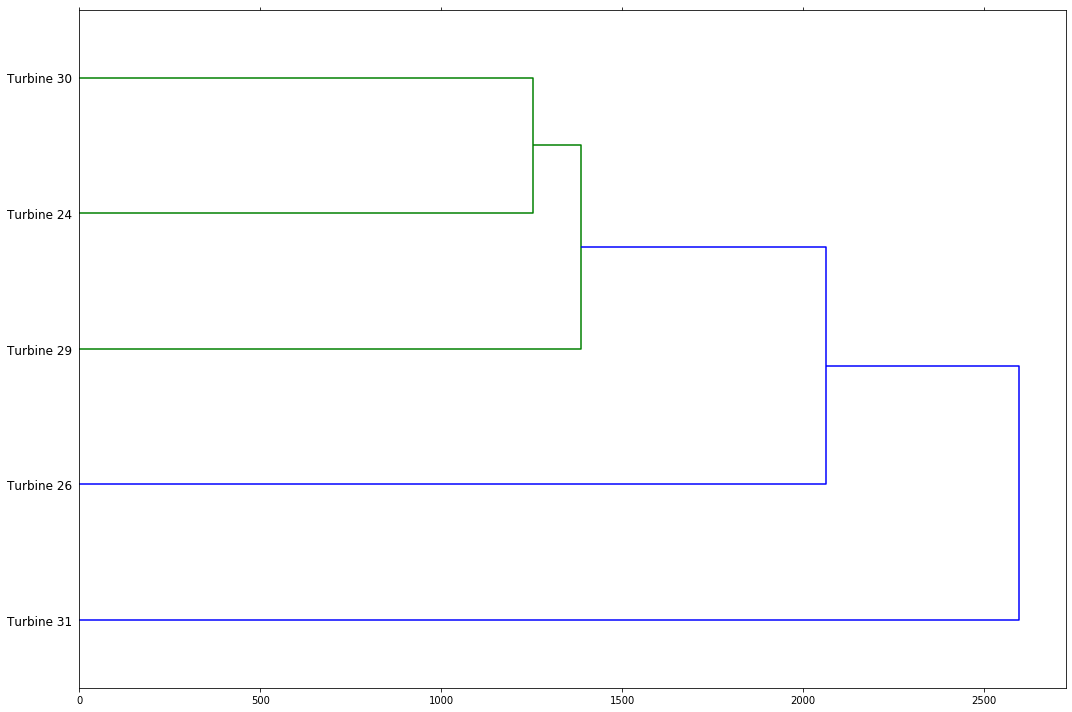

In [53]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 3: Turbines 34, 35, 36, 37, 38

In [54]:
ids = [34, 35, 36, 37, 38]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [55]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


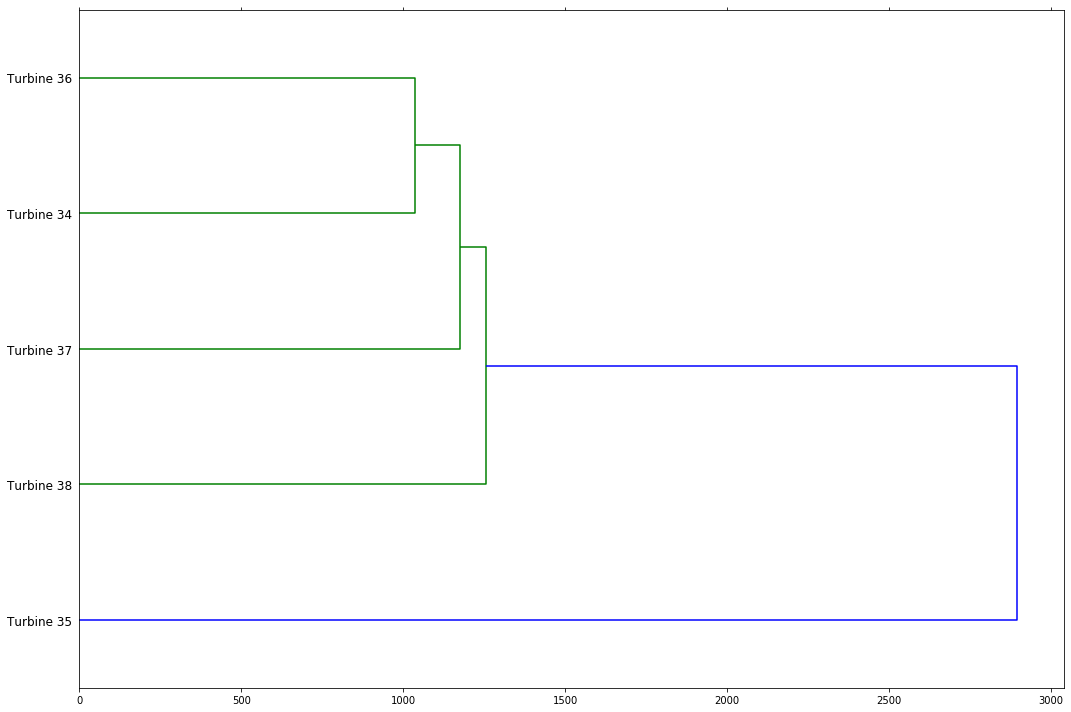

In [56]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(10, 6))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 4: Turbines 53, 55, 59, 63, 64, 65, 66, 69

In [57]:
ids = [53, 55, 59, 63, 64, 65, 66, 69]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [58]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


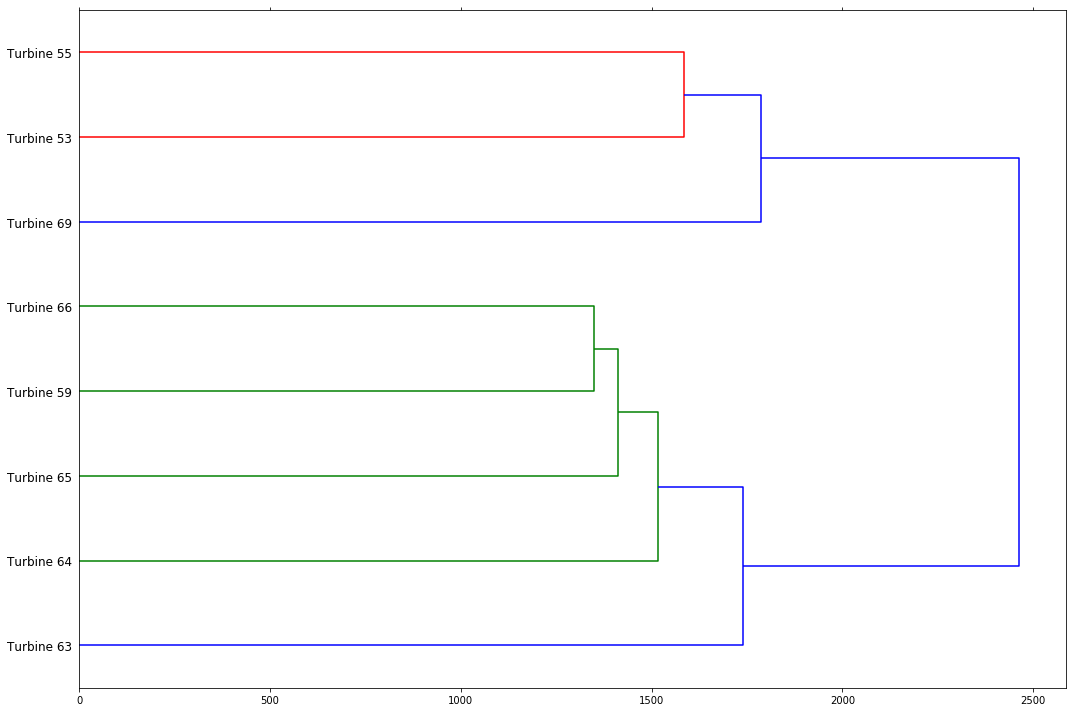

In [59]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 5: Turbines 70, 73, 76, 77, 78

In [60]:
ids = [70, 73, 76, 77, 78]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [61]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


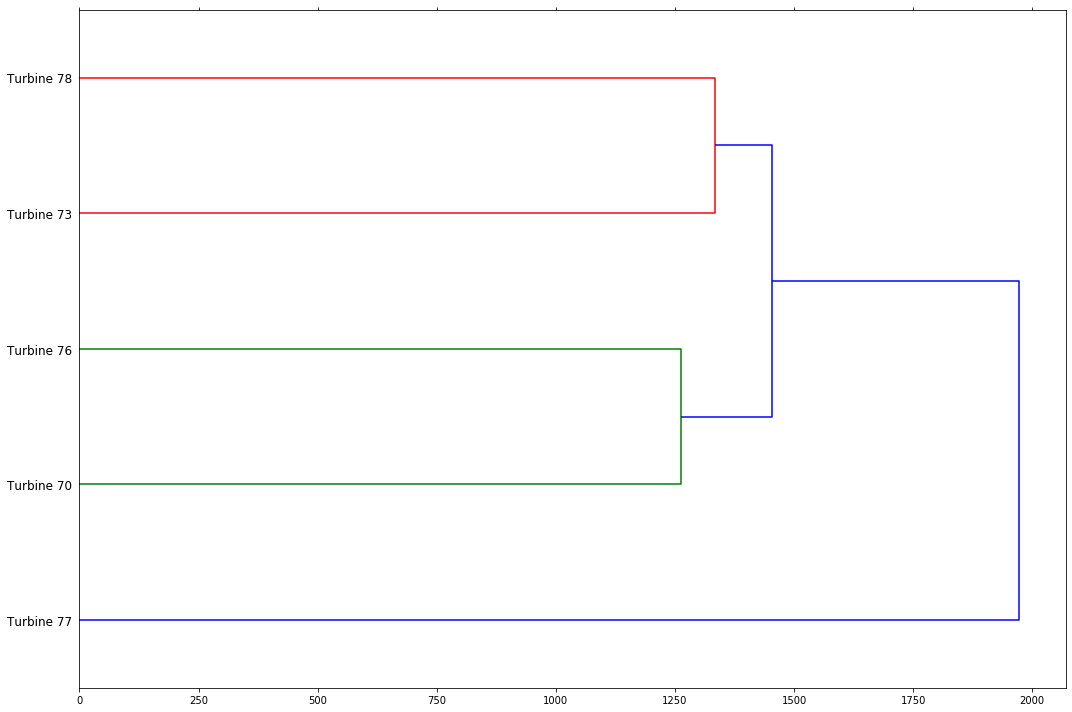

In [62]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 6: Turbines 79, 80, 81, 82, 83, 84, 85, 86

In [63]:
ids = [79, 80, 81, 82, 83, 84, 85, 86]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [64]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


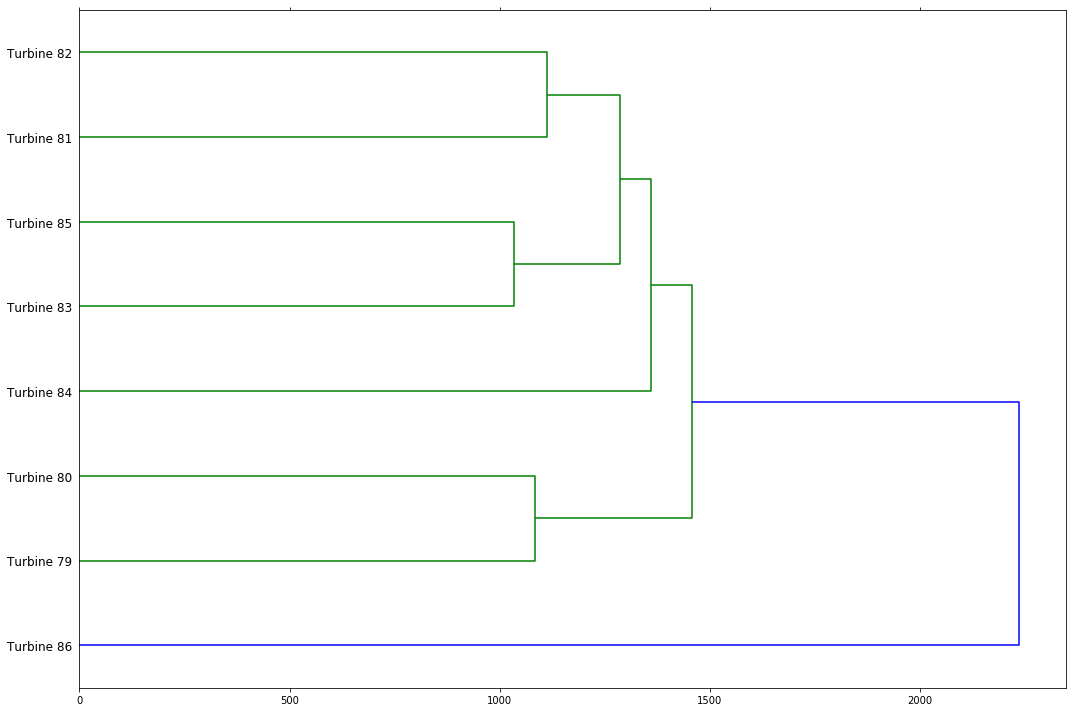

In [65]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Cluster 6: Turbines 92, 93, 94, 95, 97

In [66]:
ids = [92, 93, 94, 95, 97]
date = "2013-10-01"

distance_matrix = np.zeros((len(ids),len(ids)))

dfs = {}
for i in range(0,len(ids)):
    dfs[i] = prep_df(turbine_ids = [ids[i]], shutdown=date)
    dfs[i] = sc.fit_transform(dfs[i])

In [67]:
for i in range(0,len(ids)):
    for j in range(i+1,len(ids)):
        distance_matrix[i,j], _ = fastdtw(dfs[i], dfs[j], dist=euclidean)
        distance_matrix[j,i] = distance_matrix[i,j]

/Users/adesai/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


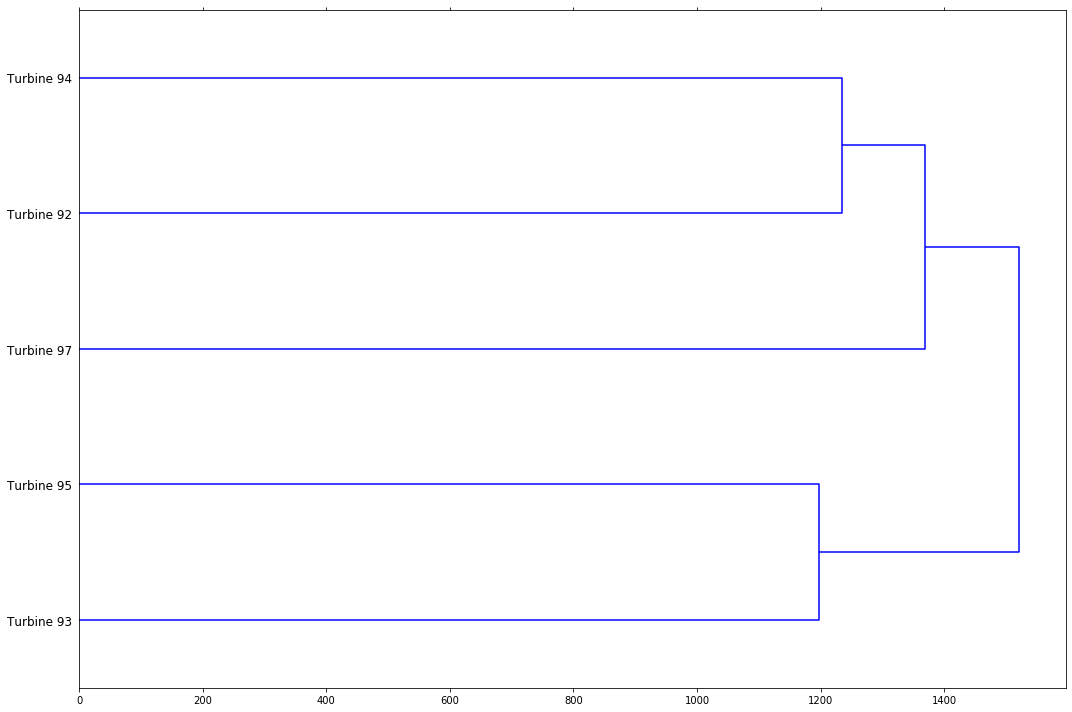

In [68]:
linkage_matrix = ward(distance_matrix)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["Turbine " + str(x) for x in ids]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()